Global Constants:
H0 = 65.5 km/s/Mpc
a_Mach (WILL limit) = 6.752e-11 m/s^2
Processing 175 galaxies...


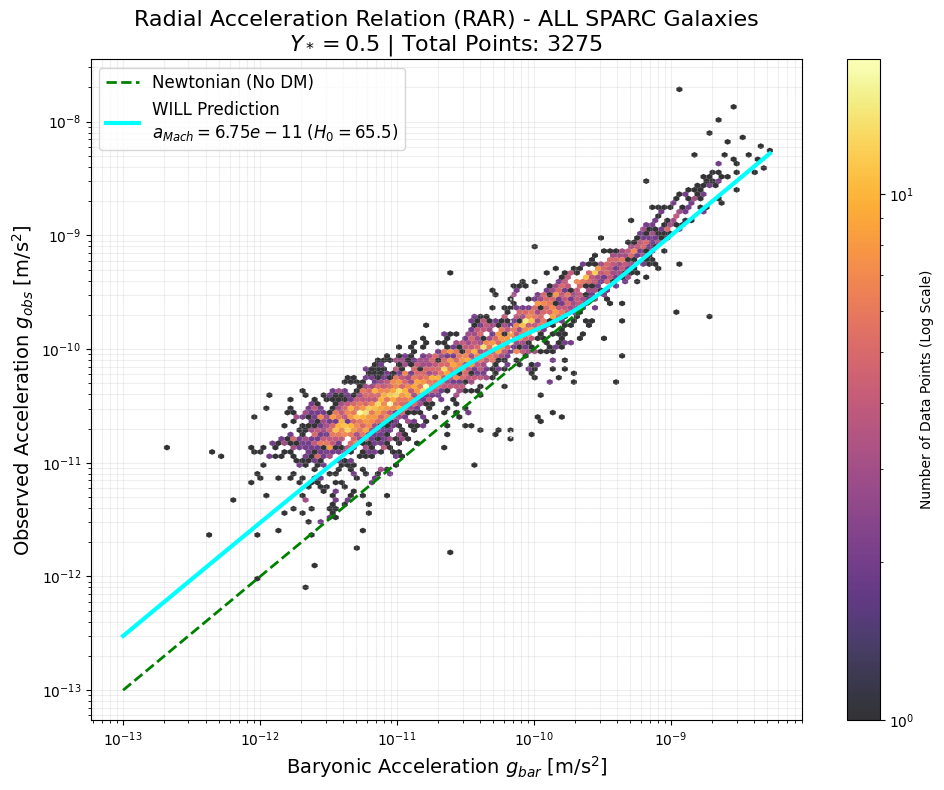

In [1]:
# WILL RAR TEST: Universal Radial Acceleration Relation
# Aggregates ALL SPARC galaxies to test the Universal Law:
# g_obs = g_bar * (1 + 2 * exp(-g_bar / a_Mach))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests, io

# -----------------------------
# CONSTANTS & SETTINGS
# -----------------------------
# Fundamental Physics
H0 = 65.5               # km/s/Mpc (Predicted by WILL)
C_KMS = 299792.458      # c in km/s
MPC_TO_M = 3.08567758e22
KPC_TO_M = 3.08567758e19

# Calculate a_Mach in m/s^2
# H0 in SI units (1/s)
H0_SI = (H0 * 1000) / MPC_TO_M
# a_Mach = c * H0 / 3pi
A_MACH = (C_KMS * 1000 * H0_SI) / (3 * np.pi)

print(f"Global Constants:")
print(f"H0 = {H0} km/s/Mpc")
print(f"a_Mach (WILL limit) = {A_MACH:.3e} m/s^2")

# Analysis Settings
Y_STAR = 0.5           # Standard M/L ratio for SPARC (Pop. Synthesis)
MIN_G = 1e-13          # Minimum acceleration to plot (to avoid log(0))
APPLY_QUALITY_CUTS = True # Filter out bad data (Inc < 30, high errors, etc)

# Data Sources
URL_T1 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table1.dat"
URL_T2 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table2.dat"

# -----------------------------
# DATA LOADING FUNCTIONS
# -----------------------------
def load_sparc_data():
    print("Downloading SPARC data...")
    # Load Table 1 (Galaxy Properties)
    r1 = requests.get(URL_T1)
    r1.raise_for_status()
    t1 = pd.read_fwf(
        io.BytesIO(r1.content),
        colspecs=[(0,11), (30,34), (113,114)], # Name, Inc, Quality
        header=None,
        names=["Name", "Inc", "Qual"]
    )
    # Clean t1
    t1["Inc"] = pd.to_numeric(t1["Inc"], errors="coerce")
    t1["Qual"] = pd.to_numeric(t1["Qual"], errors="coerce")

    # Load Table 2 (Rotation Curves)
    r2 = requests.get(URL_T2)
    r2.raise_for_status()
    t2 = pd.read_fwf(
        io.BytesIO(r2.content),
        colspecs=[(0,11), (19,25), (26,32), (33,38), (39,45), (46,52), (53,59)],
        header=None,
        names=["Name", "Rad", "Vobs", "e_Vobs", "Vgas", "Vdisk", "Vbul"]
    )
    # Convert columns to numeric
    for c in ["Rad", "Vobs", "e_Vobs", "Vgas", "Vdisk", "Vbul"]:
        t2[c] = pd.to_numeric(t2[c], errors="coerce")

    # Filter out NaNs
    t2 = t2.dropna(subset=["Name", "Rad", "Vobs"])
    # Filter out negative radii or zero velocity placeholder
    t2 = t2[(t2["Rad"] > 0) & (t2["Vobs"] > 0)]

    return t1, t2

# -----------------------------
# CALCULATION ENGINE
# -----------------------------
def calculate_accelerations(t1, t2):
    g_bar_list = []
    g_obs_list = []
    names_list = []

    # Get list of unique galaxies
    galaxies = t1["Name"].unique()

    print(f"Processing {len(galaxies)} galaxies...")

    for gal in galaxies:
        # Get galaxy info
        props = t1[t1["Name"] == gal]
        if len(props) == 0: continue
        inc = props.iloc[0]["Inc"]
        qual = props.iloc[0]["Qual"]

        # Quality Cuts (Optional but recommended for clean RAR)
        if APPLY_QUALITY_CUTS:
            if inc < 30: continue  # Face-on galaxies have huge inclination errors
            if qual > 2: continue  # Skip low quality flags

        # Get galaxy data points
        data = t2[t2["Name"] == gal].copy()
        if len(data) == 0: continue

        # 1. Calculate Baryonic Velocity V_bar
        # Formula: V_bar = sqrt( |Vgas|Vgas + Y*|Vdisk|Vdisk + Y*|Vbul|Vbul )
        # Using abs() because sometimes Vgas is negative in inner regions (holes)
        v_gas_sq = np.abs(data["Vgas"]) * data["Vgas"]
        v_disk_sq = np.abs(data["Vdisk"]) * data["Vdisk"]
        v_bul_sq = np.abs(data["Vbul"]) * data["Vbul"]

        v_bar_sq = v_gas_sq + Y_STAR * v_disk_sq + Y_STAR * v_bul_sq
        # Keep only physical (positive mass) regions
        mask = v_bar_sq > 0
        data = data[mask]
        v_bar_sq = v_bar_sq[mask]

        # 2. Convert to Accelerations (SI Units: m/s^2)
        # g = V^2 / R
        # Conversion: (km/s)^2 / kpc  -> m/s^2
        # Factor = (1000)^2 / KPC_TO_M
        conv_factor = (1000.0**2) / KPC_TO_M

        radius_kpc = data["Rad"]
        g_bar_si = (v_bar_sq / radius_kpc) * conv_factor
        g_obs_si = ((data["Vobs"]**2) / radius_kpc) * conv_factor

        # 3. Append to master lists
        # Filter out extremely small values to avoid log plot errors
        valid_points = (g_bar_si > MIN_G) & (g_obs_si > MIN_G)

        g_bar_list.extend(g_bar_si[valid_points])
        g_obs_list.extend(g_obs_si[valid_points])
        names_list.extend([gal] * np.sum(valid_points))

    return np.array(g_bar_list), np.array(g_obs_list)

# -----------------------------
# PLOTTING
# -----------------------------
def plot_rar(g_bar, g_obs):
    plt.figure(figsize=(10, 8), dpi=100)

    # 1. Plot All Data Points (The Reality)
    # Using hexbin for density visualization since there are thousands of points
    plt.hexbin(g_bar, g_obs, xscale='log', yscale='log',
               gridsize=100, cmap='inferno', mincnt=1, bins='log',
               edgecolors='none', alpha=0.8)
    cb = plt.colorbar()
    cb.set_label('Number of Data Points (Log Scale)')

    # 2. Define The Theoretical Curves (The Models)
    # Range for lines
    gb_line = np.logspace(np.log10(MIN_G), np.log10(np.max(g_bar)), 100)

    # A. Newtonian (Line of Unity)
    # g_obs = g_bar
    plt.plot(gb_line, gb_line, 'g--', linewidth=2, label='Newtonian (No DM)')

    # B. WILL Prediction (Vacuum Resonance)
    # g_obs = g_bar * (1 + 2 * exp(-g_bar / a_Mach))
    # Note: In acceleration space, the formula derived is linear g_obs relation
    # From paper: beta_Q = beta * sqrt(1 + 2exp(-Gamma))
    # Squaring: beta_Q^2 = beta^2 * (1 + 2exp(-Gamma))
    # Divide by r: g_obs = g_bar * (1 + 2exp(-g_bar/a_Mach))
    will_line = gb_line * (1.0 + 2.0 * np.exp(-gb_line / A_MACH))
    plt.plot(gb_line, will_line, color='cyan', linestyle='-', linewidth=3,
             label=f'WILL Prediction\n$a_{{Mach}} = {A_MACH:.2e}$ ($H_0={H0}$)')

    # 3. Formatting
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Baryonic Acceleration $g_{bar}$ [m/s$^2$]', fontsize=14)
    plt.ylabel(r'Observed Acceleration $g_{obs}$ [m/s$^2$]', fontsize=14)
    plt.title(f'Radial Acceleration Relation (RAR) - ALL SPARC Galaxies\n$Y_*={Y_STAR}$ | Total Points: {len(g_bar)}', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, which="both", ls="-", alpha=0.2)

    # Annotate Mach Scale
    plt.axvline(x=A_MACH, color='white', linestyle=':', alpha=0.7)
    plt.text(A_MACH*1.1, 1e-9, r'$\leftarrow a_{Mach}$', color='white', fontsize=12)

    plt.tight_layout()
    plt.show()

# -----------------------------
# MAIN EXECUTION
# -----------------------------
t1, t2 = load_sparc_data()
g_b, g_o = calculate_accelerations(t1, t2)
plot_rar(g_b, g_o)